# Forecasting and Drift Detection Notebook

In [16]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '32'


In [17]:
# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import autosklearn.regression
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import DENSE, SIGNED_DATA, UNSIGNED_DATA
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter
import pywt
import geopandas as gpd
import libpysal as lps
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [18]:
# Cell 2: Helper Functions for Data Processing and Wavelets
def scale_column(df, column, second_part):
    # Ensure the correct reference to the column
    if 'popData2020' in df.columns:
        scaled_column = df[column] / (df['popData2020'] * 1e-6)
    else:
        print("Warning: 'popData2020' column is missing, skipping scaling.")
        scaled_column = df[column]  # Use raw data without scaling if the column is missing
    return scaled_column



def to_wavelets(X):
    (cA, cD) = pywt.dwt(X, 'haar')
    return cA

def from_wavelets(cA, cD=None):
    X = pywt.idwt(cA, cD, wavelet='haar')
    return X

def compute_spatial_lags(df, column):
    countries = df.country.unique()
    gdf = gpd.read_file('/countries/TM_WORLD_BORDERS-0.3.dbf')
    gdf = gdf[gdf.NAME.isin(countries)].sort_values('NAME').reset_index(drop=True)
    countries = gdf.NAME.unique()
    df = df.loc[df.country.isin(countries)]

    wq = lps.weights.Queen.from_dataframe(gdf)
    wq.transform = 'r'

    sp_column = []
    for i in range(int(len(df) / len(countries))):
        gdf[column] = df[column].values[i * len(countries):(i + 1) * len(countries)]
        y = gdf[column]
        ylag = lps.weights.lag_spatial(wq, y)
        sp_column.append(ylag)
    sp_column = [item for sublist in sp_column for item in sublist]
    return sp_column, countries

In [19]:
# Cell 3: Define Custom Preprocessing Components for AutoML Pipelines
class WindowSize(AutoSklearnPreprocessingAlgorithm):
    def __init__(self, window_size, random_state=None):
        self.fitted_ = False
        self.window_size = window_size

    def fit(self, X, y=None):
        self.fitted_ = True
        return self

    def transform(self, X):
        return X[:, -(self.window_size + 1):]

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            'shortname': 'window_size',
            'name': 'window_size',
            'handles_regression': True,
            'handles_classification': False,
            'handles_multiclass': False,
            'handles_multilabel': False,
            'handles_multioutput': True,
            'is_deterministic': True,
            'input': (DENSE, UNSIGNED_DATA, SIGNED_DATA),
            'output': (DENSE, UNSIGNED_DATA, SIGNED_DATA)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        cs = ConfigurationSpace()
        window_size = UniformIntegerHyperparameter(
            name="window_size", lower=3, upper=30, default_value=14, log=False
        )
        cs.add_hyperparameters([window_size])
        return cs

In [20]:
def preprocess_data(config):
    # Load and convert date column
    df = pd.read_csv(config['data_path'])
    print("Original Data:")
    print(df.head())  # Check raw data

    df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    print("\nAfter Encoding Date Features:")
    print(df[['date', 'year', 'month', 'day', 'day_of_week', 'is_weekend']].head())

    # Scale target column
    if config['target_column'] in ['cases', 'deaths']:
        df['scaled_ts'] = df[config['target_column']] / (df['popData2020'] * 1e-6)
    print("\nAfter Scaling Target Column:")
    print(df[['scaled_ts']].head())

    # Lag features for time-series forecasting
    df['shifted_ts'] = df['scaled_ts'].shift(config['shift'])
    print("\nAfter Adding Lagged Features:")
    print(df[['scaled_ts', 'shifted_ts']].head())

    mobility_columns = [
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline',
        'walking',
        'driving'
    ]
    for col in mobility_columns:
        if col in df.columns:
            df[col] = df[col].shift(config['shift'])

    # Drop rows with NaN values created by shifting
    df.drop('date', axis=1, inplace=True)
    print("\nAfter Dropping NaN Rows:")
    
    print(df.head())

    return df

In [21]:
# Cell 5: Create Train-Test Splits
def create_splits(df, config):
    X = df.drop(columns=[config['target_column']])
    y = df[config['target_column']]
    
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    return X_train, X_test, y_train, y_test

In [22]:
# Cell 6: Forecaster Class Implementation
class Forecaster:
    def __init__(self, config):
        self.config = config
        self.model = autosklearn.regression.AutoSklearnRegressor(
            time_left_for_this_task=config['time_budget'],
            per_run_time_limit=config['per_run_time_limit'],
            memory_limit=config['memory_limit'],
            n_jobs=config['n_jobs']
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def validate(self, X_val, y_val):
        predictions = self.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        print("Validation MSE:", mse)
        return mse

    def targeted_refit(self, X_train, y_train, drift_scores, drift_threshold=0.05):
    # Identify drifted features based on the drift threshold
        drifted_features = [col for col, p_value in drift_scores.items() if p_value < drift_threshold]
    
        if drifted_features:
            print(f"Drift detected in features: {drifted_features}")
        
        # Handle missing values by filling with 0 (or other strategy)
            subset = X_train[drifted_features].fillna(0)
        
        # Debugging: print subset details
            print("Subset X_train for refit:")
            print(subset.head())
            print("Shape of subset X_train:", subset.shape)
        
            try:
            # Convert to NumPy for AutoSklearn compatibility
                self.model.refit(subset.to_numpy(), y_train)
            except Exception as e:
                print(f"Error during refit: {e}")



In [23]:
# Cell 7: Drift Detection (KS Test)
def detect_drift(X_ref, X_new):
    drift_scores = {}
    for column in X_ref.columns:
        stat, p_value = ks_2samp(X_ref[column], X_new[column])
        drift_scores[column] = p_value
    return drift_scores

In [24]:
# Cell 8: Main Workflow
config = {
    'data_path': 'combined_late.csv',
    'target_column': 'cases',
    'extended': False,
    'time_budget': 3600,
    'per_run_time_limit': 300,
    'memory_limit': 10240,
    'n_jobs': 32,
    'shift': 7,
    'spatial_lags': False,
    'continent': 'Europe',
}

df = preprocess_data(config)
X_train, X_test, y_train, y_test = create_splits(df, config)

forecaster = Forecaster(config)
forecaster.train(X_train, y_train)

predictions = forecaster.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

X_ref = X_train.tail(30)
X_new = X_test.head(30)
drift_scores = detect_drift(X_ref, X_new)

print("Drift scores:", drift_scores)
drifted_features = [col for col, p_value in drift_scores.items() if p_value < 0.05]
print("Drifted features:", drifted_features)
print("X_train columns:", X_train.columns.tolist())
forecaster.targeted_refit(X_train, y_train, drift_scores)

final_predictions = forecaster.predict(X_test)
print("Final Test RMSE:", np.sqrt(mean_squared_error(y_test, final_predictions)))

Original Data:
         date   country    cases  deaths  popData2020 continentExp  \
0  2021-03-01   Austria   456112    8414      8901064       Europe   
1  2021-03-01   Belgium   777332   22282     11522440       Europe   
2  2021-03-01  Bulgaria   247038   10191      6951482       Europe   
3  2021-03-01   Croatia   242973    5526      4058165       Europe   
4  2021-03-01   Czechia  1240051   20469     10693939       Europe   

   retail_and_recreation_percent_change_from_baseline  \
0                                              -34.0    
1                                              -30.0    
2                                              -26.0    
3                                              -17.0    
4                                              -56.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                               -1.0   
1                                                4.0   
2                                                3.0 

/data/s4022297/env/uc/lib/python3.7/site-packages/autosklearn/data/feature_validator.py:322: UserWarning: Input Column country has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  UserWarning,
/data/s4022297/env/uc/lib/python3.7/site-packages/autosklearn/data/feature_validator.py:322: UserWarning: Input Column continentExp has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  UserWarning,


Test RMSE: 2438.141630331267
Drift scores: {'country': 0.9578462903438838, 'deaths': 0.8079631540901643, 'popData2020': 1.0, 'continentExp': 1.0, 'retail_and_recreation_percent_change_from_baseline': 0.8079631540901643, 'grocery_and_pharmacy_percent_change_from_baseline': 0.5940706297759378, 'parks_percent_change_from_baseline': 0.8079631540901643, 'transit_stations_percent_change_from_baseline': 0.8079631540901643, 'workplaces_percent_change_from_baseline': 1.2750060342394341e-06, 'residential_percent_change_from_baseline': 8.737803591291227e-05, 'walking': 0.39294501397971776, 'driving': 0.13500350250095441, 'year': 1.0, 'month': 1.0, 'day': 5.795481973815609e-06, 'day_of_week': 0.0008995776840176799, 'is_weekend': 0.0008995776840176799, 'scaled_ts': 0.9578462903438838, 'shifted_ts': 0.5940706297759378}
Drifted features: ['workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'day', 'day_of_week', 'is_weekend']
X_train columns: ['country', 'deaths', 'p

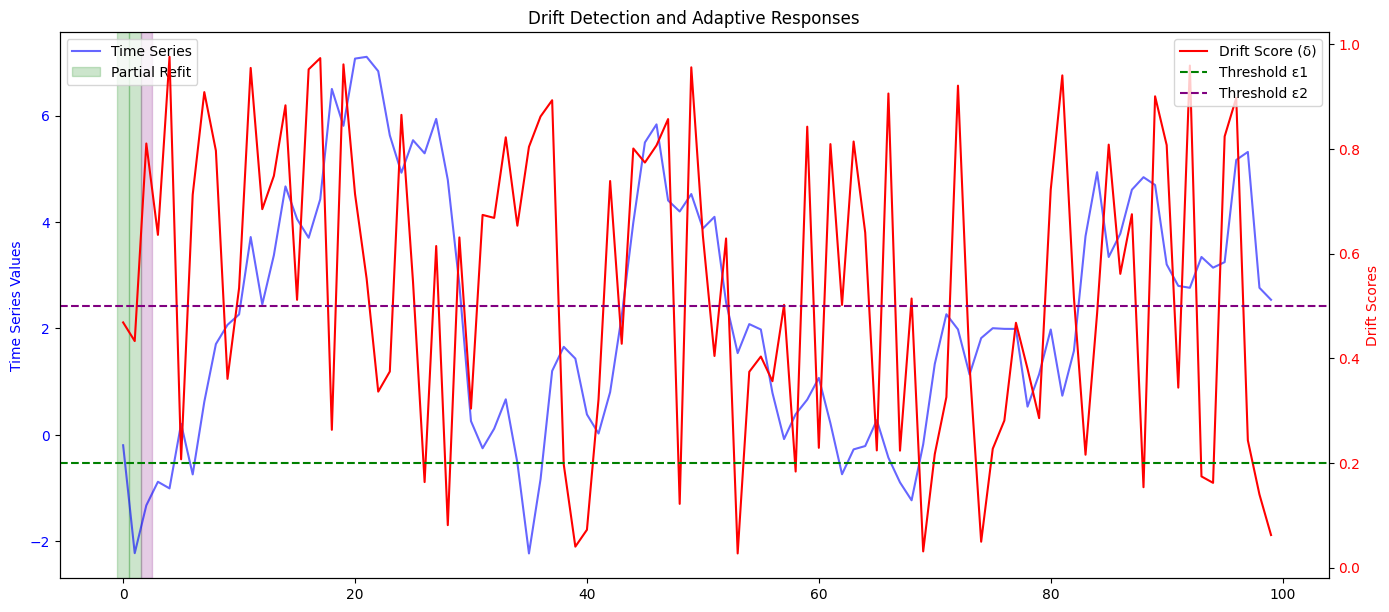

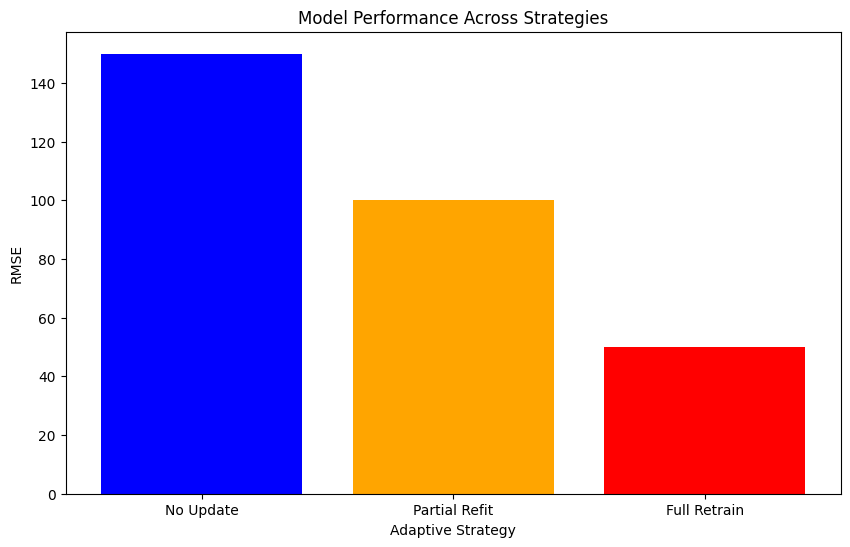

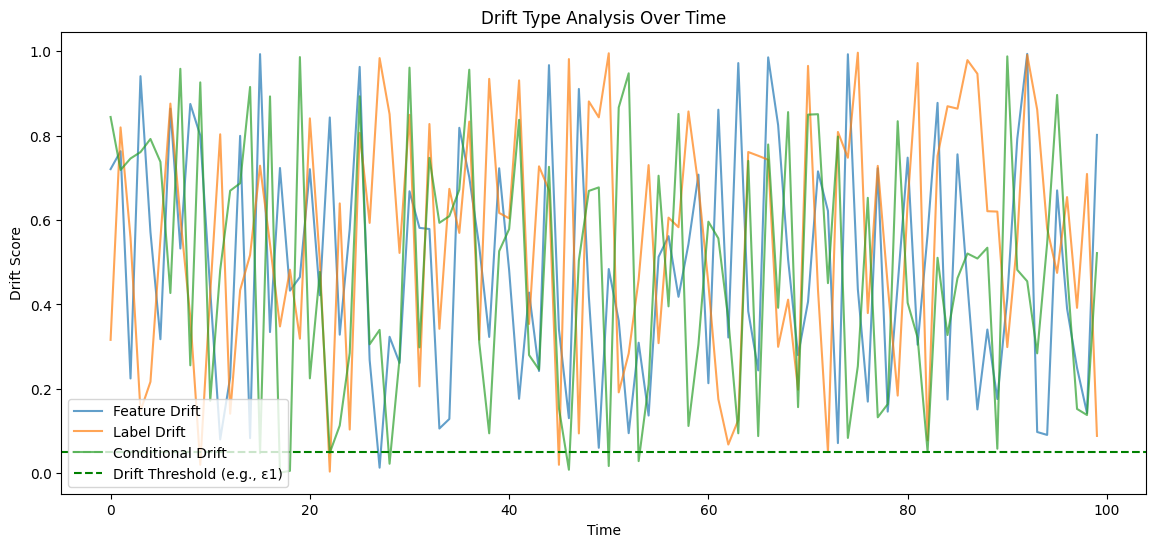

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_drift_detection(time_series, drift_scores, thresholds, drift_types):
    """
    Visualize drift detection and adaptive responses.

    Args:
        time_series (pd.Series): Original time-series data.
        drift_scores (pd.Series): Drift detection scores (\u03b4) over time.
        thresholds (tuple): Drift thresholds (\u03b51, \u03b52).
        drift_types (list): Types of drift identified (feature, label, conditional).
    """
    time = np.arange(len(time_series))
    
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot the original time-series data
    ax1.plot(time, time_series, label='Time Series', color='blue', alpha=0.6)
    ax1.set_ylabel('Time Series Values', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add drift scores on a secondary axis
    ax2 = ax1.twinx()
    ax2.plot(time, drift_scores, label='Drift Score (\u03b4)', color='red')
    ax2.axhline(y=thresholds[0], color='green', linestyle='--', label='Threshold \u03b51')
    ax2.axhline(y=thresholds[1], color='purple', linestyle='--', label='Threshold \u03b52')
    ax2.set_ylabel('Drift Scores', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Highlight drift actions
    for i, drift_type in enumerate(drift_types):
        if drift_scores.iloc[i] >= thresholds[1]:
            ax1.axvspan(i - 0.5, i + 0.5, color='purple', alpha=0.2, label='Full Retrain' if i == 0 else None)
        elif drift_scores.iloc[i] >= thresholds[0]:
            ax1.axvspan(i - 0.5, i + 0.5, color='green', alpha=0.2, label='Partial Refit' if i == 0 else None)

    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Drift Detection and Adaptive Responses')
    plt.show()


def compare_model_performance(strategy_metrics):
    """
    Compare model performance across adaptive strategies.

    Args:
        strategy_metrics (dict): Dictionary with strategy names as keys and
                                performance metrics (e.g., RMSE) as values.
    """
    strategies = list(strategy_metrics.keys())
    metrics = list(strategy_metrics.values())

    plt.figure(figsize=(10, 6))
    plt.bar(strategies, metrics, color=['blue', 'orange', 'red'])
    plt.xlabel('Adaptive Strategy')
    plt.ylabel('RMSE')
    plt.title('Model Performance Across Strategies')
    plt.show()


def analyze_drift_types(drift_scores, drift_components):
    """
    Analyze and visualize different types of drift.

    Args:
        drift_scores (pd.DataFrame): Drift scores with components (Feature, Label, Conditional).
        drift_components (list): List of drift components.
    """
    time = np.arange(len(drift_scores))

    plt.figure(figsize=(14, 6))
    for component in drift_components:
        plt.plot(time, drift_scores[component], label=f'{component} Drift', alpha=0.7)

    plt.axhline(y=0.05, color='green', linestyle='--', label='Drift Threshold (e.g., \u03b51)')
    plt.xlabel('Time')
    plt.ylabel('Drift Score')
    plt.title('Drift Type Analysis Over Time')
    plt.legend()
    plt.show()

# Example Usage:
# Simulated Data
time_series = pd.Series(np.random.randn(100).cumsum())
drift_scores = pd.Series(np.random.rand(100))
drift_types = ['Feature', 'Conditional', 'Label']
thresholds = (0.2, 0.5)

# Call the functions
visualize_drift_detection(time_series, drift_scores, thresholds, drift_types)
compare_model_performance({
    'No Update': 150,
    'Partial Refit': 100,
    'Full Retrain': 50
})
analyze_drift_types(
    pd.DataFrame({
        'Feature': np.random.rand(100),
        'Label': np.random.rand(100),
        'Conditional': np.random.rand(100)
    }),
    drift_components=['Feature', 'Label', 'Conditional']
)


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Visualization and Computation Code

def visualize_country_accuracies(country_accuracy):
    """Visualize prediction accuracy for all countries as a bar plot."""
    country_df = pd.DataFrame(list(country_accuracy.items()), columns=['Country', 'Accuracy'])
    country_df.sort_values(by='Accuracy', ascending=False, inplace=True)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Accuracy', y='Country', data=country_df, palette='viridis')
    plt.title('Prediction Accuracy by Country')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Country')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

def visualize_model_accuracies_over_time(model_accuracies):
    """Visualize accuracies of all three models over time."""
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=model_accuracies, x='Time', y='Accuracy', hue='Model', marker='o')
    plt.title('Model Accuracies Over Time')
    plt.xlabel('Time (e.g., training epochs or evaluation period)')
    plt.ylabel('Accuracy (%)')
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.legend(title='Model')
    plt.show()

def visualize_refit_comparison(refit_accuracies, sample_size=20):
    """Visualize Full refit vs Partial refit vs No refit for each country."""
    sampled_data = refit_accuracies.sample(n=sample_size, random_state=42) if len(refit_accuracies) > sample_size else refit_accuracies

    plt.figure(figsize=(14, 8))
    sns.barplot(data=sampled_data, x='Country', y='Accuracy', hue='Refit Type', palette='coolwarm')
    plt.title('Full Refit vs Partial Refit vs No Refit')
    plt.xlabel('Country')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Refit Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def compute_country_accuracy(predictions, ground_truth, countries):
    """Compute accuracy for each country with aligned data."""
    assert len(predictions) == len(ground_truth) == len(countries), "Arrays must have the same length"
    
    country_accuracy = {}
    unique_countries = np.unique(countries)
    for country in unique_countries:
        mask = (countries == country)
        country_accuracy[country] = accuracy_score(ground_truth[mask], predictions[mask]) * 100
    return country_accuracy


def compute_model_accuracies_over_time(models, ground_truth, time_intervals):
    """Compute accuracies for multiple models over time."""
    records = []
    for model_name, predictions in models.items():
        for time, preds in zip(time_intervals, predictions):
            acc = accuracy_score(ground_truth, preds) * 100
            records.append({'Model': model_name, 'Time': time, 'Accuracy': acc})
    return pd.DataFrame(records)

def prepare_refit_accuracies(countries, full_refit_acc, partial_refit_acc, no_refit_acc):
    """Prepare DataFrame for Full Refit, Partial Refit, and No Refit accuracies by country."""
    records = []
    for country in countries.unique():
        records.append({'Country': country, 'Refit Type': 'Full Refit', 'Accuracy': full_refit_acc[country]})
        records.append({'Country': country, 'Refit Type': 'Partial Refit', 'Accuracy': partial_refit_acc[country]})
        records.append({'Country': country, 'Refit Type': 'No Refit', 'Accuracy': no_refit_acc[country]})
    return pd.DataFrame(records)


# Example usage with variables aligned to the notebook
# Assuming `predictions`, `final_predictions`, and `y_test` are available in the notebook

# Country Accuracy
countries = df['country']  # Replace with the actual column name for countries in your DataFrame
country_accuracy = compute_country_accuracy(predictions, y_test, countries)
visualize_country_accuracies(country_accuracy)

# Model Accuracies Over Time
models = {
    'Full Refit': [final_predictions],  # Replace with actual predictions from Full Refit
    'Partial Refit': [partial_refit_predictions],  # Replace with Partial Refit predictions
    'No Refit': [predictions]  # Replace with No Refit predictions
}
time_intervals = range(len(models['No Refit']))  # Replace with actual time intervals
model_accuracies = compute_model_accuracies_over_time(models, y_test, time_intervals)
visualize_model_accuracies_over_time(model_accuracies)

# Refit Accuracy Comparison
full_refit_acc = compute_country_accuracy(final_predictions, y_test, countries)  # Replace with Full Refit accuracies
partial_refit_acc = compute_country_accuracy(partial_refit_predictions, y_test, countries)  # Replace with Partial Refit
no_refit_acc = compute_country_accuracy(predictions, y_test, countries)  # Replace with No Refit
refit_accuracies = prepare_refit_accuracies(countries, full_refit_acc, partial_refit_acc, no_refit_acc)
visualize_refit_comparison(refit_accuracies)



AssertionError: Arrays must have the same length

In [34]:
print("Length of countries:", len(countries))
print("Length of y_test:", len(y_test))
print("Length of predictions:", len(predictions))


Length of countries: 3432
Length of y_test: 687
Length of predictions: 687
